In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import time

In [28]:
# Dosya yolu
file_path = "Student Depression Dataset.csv"

# CSV dosyasını okuma
df = pd.read_csv(file_path)

# Eksik verileri doldurma (ortalama ile)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Gerekli sütunları seçme
features = ["Academic Pressure", "Work Pressure", "Study Satisfaction", "Sleep Duration", "Dietary Habits", "Financial Stress", "Family History of Mental Illness"]
target = "Depression"

# Kategorik verileri sayısal hale getirme
category_mappings = {}
for col in ["Sleep Duration", "Dietary Habits", "Family History of Mental Illness"]:
    unique_values = df[col].unique()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    df[col] = df[col].map(mapping)
    category_mappings[col] = mapping


In [29]:
# Bağımsız ve bağımlı değişkenleri ayırma
X = df[features].values
y = df[target].values

# Normalizasyon uygulama
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Veriyi eğitim ve test kümelerine ayırma
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, test_idx = indices[:split], indices[split:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [30]:
# Naive Bayes sınıfı
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {}
        self.stds = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = X_c.mean(axis=0)
            self.stds[c] = X_c.std(axis=0) + 1e-6  # Sıfır bölme hatasını önlemek için küçük bir değer eklenir
            self.priors[c] = len(X_c) / len(X)
    
    def gaussian_pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((x - mean) ** 2) / (2 * std ** 2))
    
    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                prior = np.log(self.priors[c])
                likelihood = np.sum(np.log(self.gaussian_pdf(x, self.means[c], self.stds[c])))
                posteriors[c] = prior + likelihood
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)


Eğitim süresi: 0.002419 saniye
Test süresi: 0.084444 saniye
Model Doğruluk Oranı: 0.79


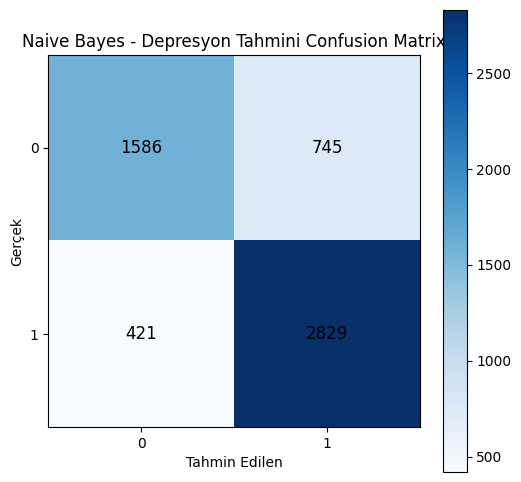

In [31]:
# Modeli eğitme ve eğitim süresini ölçme
model = NaiveBayes()
start_fit = time.time()
model.fit(X_train, y_train)
fit_time = time.time() - start_fit
print(f"Eğitim süresi: {fit_time:.6f} saniye")

# Test işlemi ve tahmin süresini ölçme
start_pred = time.time()
y_pred = model.predict(X_test)
pred_time = time.time() - start_pred
print(f"Test süresi: {pred_time:.6f} saniye")

# Modelin doğruluk oranını hesaplama
accuracy = np.mean(y_pred == y_test)
print(f"Model Doğruluk Oranı: {accuracy:.2f}")

# Confusion Matrix oluşturma
cm = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)
for true, pred in zip(y_test, y_pred):
    cm[true, pred] += 1

# Matplotlib ile confusion matrix çizdirme
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()

# Confusion matrix üzerine değerleri ekleyelim
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.xticks(np.arange(len(np.unique(y))), np.unique(y))
plt.yticks(np.arange(len(np.unique(y))), np.unique(y))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Naive Bayes - Depresyon Tahmini Confusion Matrix")
plt.show()
